In [1]:
display("text/html", "<style>.container { width:100% !important; }</style>")

In [2]:
using Plots
using Distributed
using LinearAlgebra

num_cores = length(Sys.cpu_info()) # 96 cores were used below
if nprocs()==1
    addprocs(num_cores; exeflags=`--project=$(Base.active_project())`)
end

@everywhere begin
    using LatticeAlgorithms
    using LinearAlgebra
    using Dates
end
using JLD2

      From worker 7:	┌ Info: CondaPkg: Waiting for lock to be freed. You may delete this file if no other process is resolving.
      From worker 7:	└   lock_file = "/local/home/maolinml/run_test/latticealgorithms.jl/.CondaPkg/lock"
      From worker 36:	┌ Info: CondaPkg: Waiting for lock to be freed. You may delete this file if no other process is resolving.
      From worker 36:	└   lock_file = "/local/home/maolinml/run_test/latticealgorithms.jl/.CondaPkg/lock"
      From worker 63:	┌ Info: CondaPkg: Waiting for lock to be freed. You may delete this file if no other process is resolving.
      From worker 63:	└   lock_file = "/local/home/maolinml/run_test/latticealgorithms.jl/.CondaPkg/lock"
      From worker 97:	┌ Info: CondaPkg: Waiting for lock to be freed. You may delete this file if no other process is resolving.
      From worker 97:	└   lock_file = "/local/home/maolinml/run_test/latticealgorithms.jl/.CondaPkg/lock"
      From worker 59:	┌ Info: CondaPkg: Waiting for lock to be

      From worker 19:	┌ Info: CondaPkg: Waiting for lock to be freed. You may delete this file if no other process is resolving.
      From worker 19:	└   lock_file = "/local/home/maolinml/run_test/latticealgorithms.jl/.CondaPkg/lock"
      From worker 77:	┌ Info: CondaPkg: Waiting for lock to be freed. You may delete this file if no other process is resolving.
      From worker 77:	└   lock_file = "/local/home/maolinml/run_test/latticealgorithms.jl/.CondaPkg/lock"
      From worker 44:	┌ Info: CondaPkg: Waiting for lock to be freed. You may delete this file if no other process is resolving.
      From worker 44:	└   lock_file = "/local/home/maolinml/run_test/latticealgorithms.jl/.CondaPkg/lock"
      From worker 57:	┌ Info: CondaPkg: Waiting for lock to be freed. You may delete this file if no other process is resolving.
      From worker 57:	└   lock_file = "/local/home/maolinml/run_test/latticealgorithms.jl/.CondaPkg/lock"
      From worker 2:	┌ Info: CondaPkg: Waiting for lock to b

      From worker 29:	┌ Info: CondaPkg: Waiting for lock to be freed. You may delete this file if no other process is resolving.
      From worker 29:	└   lock_file = "/local/home/maolinml/run_test/latticealgorithms.jl/.CondaPkg/lock"
      From worker 22:	┌ Info: CondaPkg: Waiting for lock to be freed. You may delete this file if no other process is resolving.
      From worker 22:	└   lock_file = "/local/home/maolinml/run_test/latticealgorithms.jl/.CondaPkg/lock"
      From worker 3:	┌ Info: CondaPkg: Waiting for lock to be freed. You may delete this file if no other process is resolving.
      From worker 3:	└   lock_file = "/local/home/maolinml/run_test/latticealgorithms.jl/.CondaPkg/lock"
      From worker 90:	┌ Info: CondaPkg: Waiting for lock to be freed. You may delete this file if no other process is resolving.
      From worker 90:	└   lock_file = "/local/home/maolinml/run_test/latticealgorithms.jl/.CondaPkg/lock"
      From worker 73:	┌ Info: CondaPkg: Waiting for lock to be

In [35]:
@everywhere begin
    type_lattice = "hex" # "square", "hex"
    if type_lattice == "hex"
        S = [2 1; 0 √3] / (12)^(1/4) # cannot be [2 0; 1 √3] / (12)^(1/4)
    else
        S = [1 0; 0 1]
    end

    S_T = Matrix(transpose(S))
    M = [√2 0; 0 √2] * S_T
    Ω = Ω_matrix(M)
    Mperp = GKP_logical_operator_generator(M)    
end

σrange = vcat(0.50:0.01:0.59, 0.591:0.001:0.607, exp(-1/2))

num_samples = Int(1e7)

num_samples_each_core = Int(ceil(num_samples/num_cores))
num_total_samples = Int(num_samples_each_core * num_cores);
println([num_samples_each_core, num_samples, num_total_samples])

logfile = "mld_$(type_lattice)_$(min(σrange...))_$(max(σrange...))_$(num_total_samples)_log.txt"
    open(logfile, "w") do file
end

[104167, 10000000, 10000032]


In [36]:
@time results = pmap(1:num_cores) do _
    p_list = Dict(σrange.=>[[0.0, 0.0, 0.0, 0.0] for _ in 1 : length(σrange)])
    t_list = Dict(σrange.=>[0.0 for _ in 1 : length(σrange)])

    for (ind_σ, σ) in enumerate(σrange)

        p = [0.0, 0.0, 0.0, 0.0]
        t = 0        

        σtime = @elapsed for _ in 1 : num_samples_each_core
            ξ = σ * randn(2)

            ξ2 = -√(2π) * M * Ω * ξ
            s = ξ2 - floor.(ξ2/(2π)) * 2π
            ηs = -transpose(Ω*Mperp) * s/√(2π) ; 
            b = inv(√(2π) * transpose(Mperp)) * (ηs-ξ)
            @assert norm(round.(Int, b) - b) < 1e-10   
            
            X = √π * S * [1, 0]
            Z = √π * S * [0, 1]                
            
            Y = X+Z
            
            t += @elapsed begin
                
                ws = get_ws_non_square(ηs, σ; S = S, Nv=5)[1]

                rec = -ηs
                maxw = max(ws...)

                if maxw == ws[1]
                    rec += [0.0, 0.0]
                elseif maxw == ws[2]
                    rec += X
                elseif maxw == ws[3]
                    rec += Z
                elseif maxw == ws[4]
                    rec += Y
                end
                
                final_error = (rec+ξ)

                nx = transpose(final_error) * Ω * Z / π
                nz = transpose(final_error) * Ω * X / π
                nx = mod(round(nx), 2)
                nz = mod(round(nz), 2)
                @assert round.(Int, nx) ≈ nx
                @assert round.(Int, nz) ≈ nz  

                ##########
                if nx ≈ 0 && nz ≈ 0
                    p[1] += 1
                elseif nx ≈ 1 && nz ≈ 0
                    p[2] += 1
                elseif nx ≈ 0 && nz ≈ 1
                    p[3] += 1
                elseif nx ≈ 1 && nz ≈ 1
                    p[4] += 1
                end    
                
            end
        end
        p_list[σ] += p
        t_list[σ] += t

        if myid() == 2 # Print the progress of the 2nd worker
            println(["$(ind_σ)/$(length(σrange)), $(σtime), $(string(now()))"])
        end
    end
    
    return p_list, t_list
end ;     

t_list = merge(+, [res[2] for res in results]...) 
p_list = merge(+, [res[1] for res in results]...)

map!(v->v./num_total_samples, values(t_list))
map!(v->v./num_total_samples, values(p_list))

c_list = Dict()

for (k, v) in p_list
    c_list[k] = coherent_information_pauli_channel(v[2], v[4], v[3])
end

# Save the result
fn = "mld_$(type_lattice)_$(min(σrange...))_$(max(σrange...))_$(num_total_samples).jld2";
jldsave(fn; 
    σrange=σrange, 
    num_samples=num_samples_each_core*num_cores,
    p_list = p_list,
    t_list = t_list,
    c_list = c_list,
)


      From worker 2:	["1/28, 58.010479991, 2024-10-13T05:34:52.505"]
      From worker 2:	["2/28, 57.253262985, 2024-10-13T05:35:49.759"]
      From worker 2:	["3/28, 58.022182944, 2024-10-13T05:36:47.783"]
      From worker 2:	["4/28, 57.972276357, 2024-10-13T05:37:45.756"]
      From worker 2:	["5/28, 58.091034416, 2024-10-13T05:38:43.849"]
      From worker 2:	["6/28, 58.006181145, 2024-10-13T05:39:41.856"]
      From worker 2:	["7/28, 57.640914218, 2024-10-13T05:40:39.498"]
      From worker 2:	["8/28, 57.780093245, 2024-10-13T05:41:37.279"]
      From worker 2:	["9/28, 57.647291141, 2024-10-13T05:42:34.927"]
      From worker 2:	["10/28, 57.803467993, 2024-10-13T05:43:32.732"]
      From worker 2:	["11/28, 57.701106463, 2024-10-13T05:44:30.434"]
      From worker 2:	["12/28, 57.715954637, 2024-10-13T05:45:28.151"]
      From worker 2:	["13/28, 57.832253737, 2024-10-13T05:46:25.984"]
      From worker 2:	["14/28, 57.645251782, 2024-10-13T05:47:23.629"]
      From worker 2:	["15/28,

In [37]:
sort(load(fn)["p_list"])

OrderedCollections.OrderedDict{Float64, Vector{Float64}} with 28 entries:
  0.5   => [0.862624, 0.0457968, 0.045811, 0.0457683]
  0.51  => [0.851754, 0.0494034, 0.0493519, 0.0494902]
  0.52  => [0.840563, 0.0532097, 0.0531402, 0.0530874]
  0.53  => [0.829322, 0.0568649, 0.0569055, 0.0569078]
  0.54  => [0.818199, 0.0605262, 0.0607117, 0.0605635]
  0.55  => [0.806781, 0.0643277, 0.0643988, 0.0644921]
  0.56  => [0.795108, 0.0682777, 0.0683091, 0.0683049]
  0.57  => [0.783537, 0.0721383, 0.0721169, 0.0722079]
  0.58  => [0.771715, 0.0761181, 0.0760867, 0.0760799]
  0.59  => [0.76042, 0.0800417, 0.0797333, 0.0798044]
  0.591 => [0.759154, 0.0801676, 0.0804736, 0.0802044]
  0.592 => [0.758027, 0.0805385, 0.0807314, 0.0807029]
  0.593 => [0.756851, 0.0809906, 0.0811106, 0.0810479]
  0.594 => [0.755782, 0.0814508, 0.0814709, 0.0812958]
  0.595 => [0.754702, 0.0818622, 0.0816358, 0.0817997]
  0.596 => [0.753485, 0.0821666, 0.0820799, 0.0822681]
  0.597 => [0.75234, 0.082675, 0.0825175, 0.0824

# Compare to existing data: Square

In [11]:
function get_p0list_sorted(p_list, drange, σrange)
    p0list_sorted = sort(p_list)
    p0list_sorted = collect(values(p0list_sorted))
    p0list_sorted = reshape(p0list_sorted, (length(drange), length(σrange)))
    p0list_sorted = [p0list_sorted[:,i] for i in 1:size(p0list_sorted,2)]
    return p0list_sorted
end


get_p0list_sorted (generic function with 1 method)

In [38]:
new_data_square = sort(load("mld_square_0.5_0.607_10000032.jld2"))
new_p_list = new_data_square["p_list"]
new_p_list_sorted = get_p0list_sorted(new_p_list, [1], σrange)

28-element Vector{Vector{Vector{Float64}}}:
 [[0.8532323696564171, 0.07055297423048246, 0.07039537473480084, 0.0058192813782995895]]
 [[0.842179305026224, 0.07556775818317381, 0.07543825859757249, 0.0068146781930297825]]
 [[0.8312756399179523, 0.08044774256722378, 0.08052334232530456, 0.007753275189519394]]
 [[0.8199503761587963, 0.08565722589687713, 0.08548042646263532, 0.00891197148169126]]
 [[0.8086309123810804, 0.09066220988092838, 0.09058091014108755, 0.01012596759690369]]
 [[0.7971471491291228, 0.09567549383841972, 0.09565299391041948, 0.01152436312203801]]
 [[0.7860162847478888, 0.10055357822854967, 0.1005565782189497, 0.012873558804611825]]
 [[0.7742941222588088, 0.10561376203596148, 0.10575446158572292, 0.014337654119506818]]
 [[0.7629179586625323, 0.11049304642225145, 0.11059224610481247, 0.015996748810403808]]
 [[0.7517844942896182, 0.11516443147381929, 0.1153223309685409, 0.01772874326802154]]
 [[0.7504255986380843, 0.11570832973334486, 0.11597462888118758, 0.01789144274738

In [39]:
## 
old_data_square_1 = sort(load("data/raw_data/mld_square_0.5_0.6_10000128.jld2"))
old_p_list_1 = old_data_square_1["p_list"]
old_p_list_1_sorted = get_p0list_sorted(old_p_list_1, [1], old_data_square_1["σrange"])
display(old_p_list_1_sorted)

old_data_square_2 = sort(load("data/raw_data/mld_square_0.601_0.607_10000128.jld2"))
old_p_list_2 = old_data_square_2["p_list"]
old_p_list_2_sorted = get_p0list_sorted(old_p_list_2, [1], old_data_square_2["σrange"])    
display(old_p_list_2_sorted)

11-element Vector{Vector{Vector{Float64}}}:
 [[0.8532441784745155, 0.07051289743491283, 0.07040909876353582, 0.005833825327035814]]
 [[0.8422639190218365, 0.07543433444051915, 0.07554913297109797, 0.006752613566546348]]
 [[0.8312016606187441, 0.08044967024422088, 0.08054936896807721, 0.007799300168957838]]
 [[0.8199992040101887, 0.08561540412282723, 0.08545360619384072, 0.008931785673143384]]
 [[0.8085598504339144, 0.09079753779151627, 0.09058204054988096, 0.010060571224688324]]
 [[0.7973492939290378, 0.09565177565727159, 0.0955413770703735, 0.011457553343317205]]
 [[0.7858810407226787, 0.10069671108209816, 0.10058021257327907, 0.01284203562194404]]
 [[0.7744318872718429, 0.10570894692547936, 0.10548554978496276, 0.014373616017714974]]
 [[0.7631794313032794, 0.11037948714256457, 0.11046948599057932, 0.015971595563576788]]
 [[0.7513868822479072, 0.11539462294882626, 0.11545022223715537, 0.017768272566111153]]
 [[0.7400830269372553, 0.12012606238640146, 0.12027106053042522, 0.01951985014

7-element Vector{Vector{Vector{Float64}}}:
 [[0.7390078406996391, 0.12075905428410516, 0.12058285653943629, 0.019650248476819496]]
 [[0.7379058548050585, 0.12124964800450554, 0.12096025170877812, 0.019884245481657833]]
 [[0.7367967690013568, 0.12162524319688708, 0.12152184452039014, 0.020056143281366]]
 [[0.7359091803624913, 0.12182934058444052, 0.12202053813711185, 0.020240940915956275]]
 [[0.7345561976806697, 0.12262743036889127, 0.12238903342037222, 0.020427338530066817]]
 [[0.7333626129585541, 0.123040825077439, 0.1230291252271971, 0.020567436736809767]]
 [[0.7321204288585106, 0.12367021702122213, 0.12344001996774441, 0.02076933415252285]]

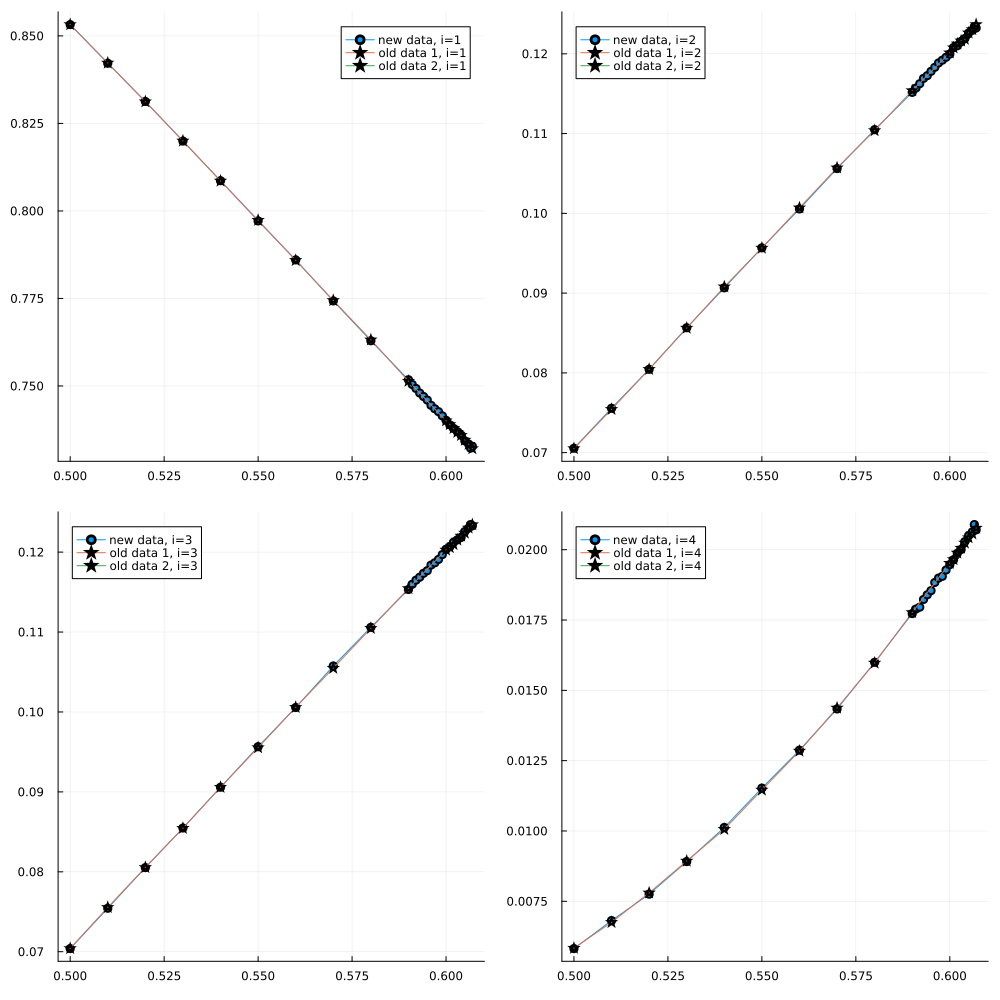

In [40]:
gs = []
for i in 1:4
    g = plot()
    plot!(σrange, [item[1][i] for item in new_p_list_sorted], marker=:circle, label="new data, i=$i")
    plot!(old_data_square_1["σrange"], [item[1][i] for item in old_p_list_1_sorted], marker=:star, label="old data 1, i=$i")
    plot!(old_data_square_2["σrange"], [item[1][i] for item in old_p_list_2_sorted], marker=:star, label="old data 2, i=$i")    
    push!(gs, g)
end
plot(gs..., size=(1000, 1000))

# Compare to existing data: Hex

In [41]:
new_data_hex = sort(load("mld_hex_0.5_0.607_10000032.jld2"))
new_p_list = new_data_hex["p_list"]
new_p_list_sorted = get_p0list_sorted(new_p_list, [1], σrange)

28-element Vector{Vector{Vector{Float64}}}:
 [[0.8626240396030733, 0.04579675345038896, 0.045810953404949104, 0.045768253541588665]]
 [[0.851754374386002, 0.04940344190898589, 0.04935194207378536, 0.04949024163122678]]
 [[0.8405626101996474, 0.05320972972886487, 0.053140229951264155, 0.053087430120223614]]
 [[0.8293217461704122, 0.0568649180322623, 0.05690551790234271, 0.05690781789498273]]
 [[0.8181985817645383, 0.06052620631613979, 0.06071170572254169, 0.06056350619678017]]
 [[0.8067814182994615, 0.06432769415137872, 0.06439879392385944, 0.0644920936253004]]
 [[0.7951083556532619, 0.06827768151141916, 0.06830908141093948, 0.06830488142437945]]
 [[0.7835369926816235, 0.0721382691575387, 0.07211686922601848, 0.07220786893481941]]
 [[0.7717154305106224, 0.07611805642221944, 0.07608665652269912, 0.07607985654445906]]
 [[0.7604204666545067, 0.08004174386641963, 0.07973334485329647, 0.0798044446257772]]
 [[0.7591542707063338, 0.08016764346354091, 0.08047364248434405, 0.08020444334578129]]


In [43]:
## 
old_data_hex_1 = sort(load("data/raw_data/mld_hex_0.5_0.6_10000128.jld2"))
old_p_list_1 = old_data_hex_1["p_list"]
old_p_list_1_sorted = get_p0list_sorted(old_p_list_1, [1], old_data_hex_1["σrange"])
display(old_p_list_1_sorted)

old_data_hex_2 = sort(load("data/raw_data/mld_hex_0.601_0.607_10000128.jld2"))
old_p_list_2 = old_data_hex_2["p_list"]
old_p_list_2_sorted = get_p0list_sorted(old_p_list_2, [1], old_data_hex_2["σrange"])    
display(old_p_list_2_sorted)

11-element Vector{Vector{Vector{Float64}}}:
 [[0.8628082560543225, 0.04577651406062003, 0.045610816181552875, 0.0458044137035046]]
 [[0.8519378951949415, 0.04940686759209482, 0.04942296738601746, 0.049232269826946215]]
 [[0.8405094414791491, 0.05316741945703095, 0.05315801957734941, 0.053165119486470576]]
 [[0.8297019798146583, 0.05669297432992858, 0.056871672042597854, 0.056733373812815194]]
 [[0.818200427034534, 0.06059932432864859, 0.06068992316898344, 0.06051032546783401]]
 [[0.8065246764841411, 0.06443227526687659, 0.06456617355297853, 0.0644768746960039]]
 [[0.7950850229117067, 0.06833382532703582, 0.06831952551007348, 0.06826162625118398]]
 [[0.7834401719657988, 0.07218487603358677, 0.07217207619742468, 0.07220287580318972]]
 [[0.7716996222448352, 0.07604542661853929, 0.07609672596190768, 0.07615822517471776]]
 [[0.7604018668561042, 0.07983137815835957, 0.07995377659165963, 0.07981297839387656]]
 [[0.7485126190384763, 0.08370152862043366, 0.08392612574559045, 0.08385972659549958

7-element Vector{Vector{Vector{Float64}}}:
 [[0.747815027967642, 0.08399432487264163, 0.08415202285410747, 0.08403862430560889]]
 [[0.7465604440263165, 0.08454841778025242, 0.0843250206397358, 0.08456611755369531]]
 [[0.7455461570091902, 0.08489111339374857, 0.08469101595499577, 0.08487171364206539]]
 [[0.744275173277782, 0.08524390887796636, 0.08517910970739574, 0.08530180813685585]]
 [[0.7432073869454471, 0.08558500451194224, 0.0856091042034662, 0.08559850433914445]]
 [[0.741931003283158, 0.08592420017023782, 0.08610989779330824, 0.08603489875329595]]
 [[0.7409952152612447, 0.08633829486982567, 0.08634839474054733, 0.08631809512838236]]

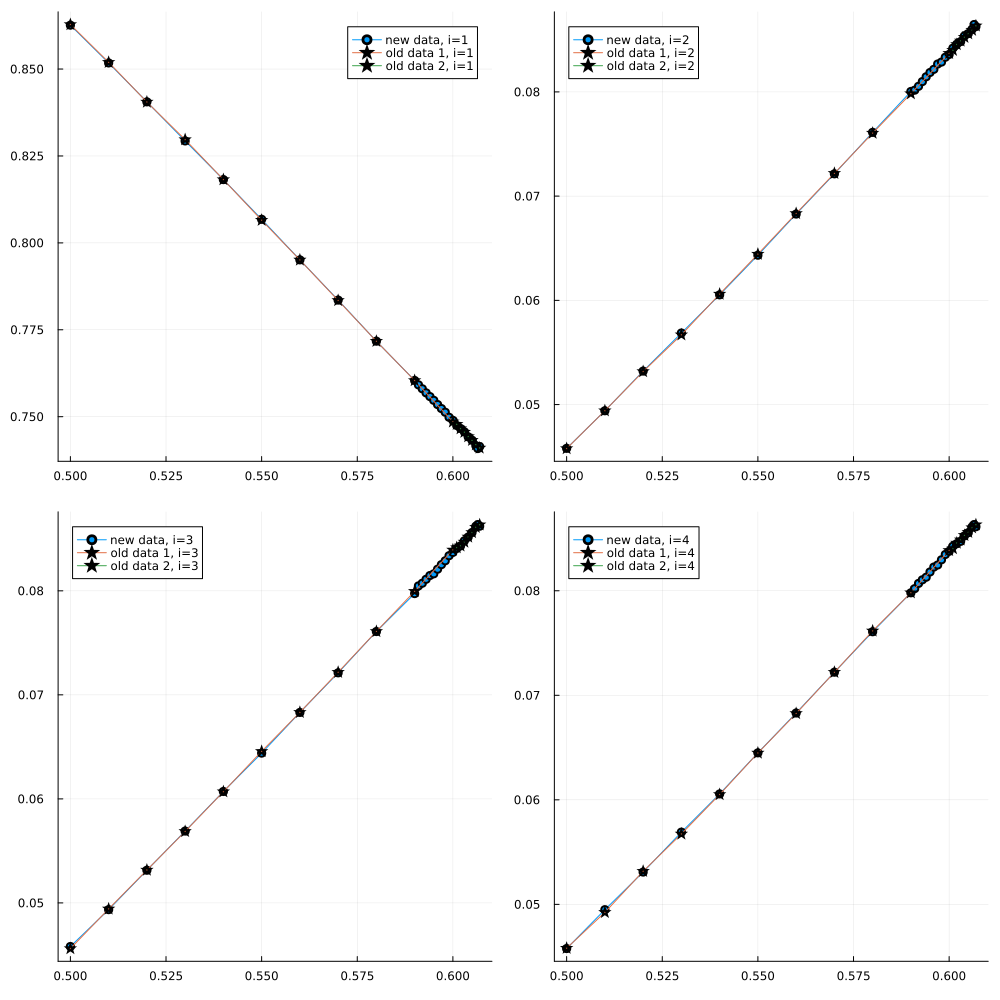

In [44]:
gs = []
for i in 1:4
    g = plot()
    plot!(σrange, [item[1][i] for item in new_p_list_sorted], marker=:circle, label="new data, i=$i")
    plot!(old_data_square_1["σrange"], [item[1][i] for item in old_p_list_1_sorted], marker=:star, label="old data 1, i=$i")
    plot!(old_data_square_2["σrange"], [item[1][i] for item in old_p_list_2_sorted], marker=:star, label="old data 2, i=$i")    
    push!(gs, g)
end
plot(gs..., size=(1000, 1000))